<a href="https://colab.research.google.com/github/tiagoaos/tcc-machine-learning-dolar/blob/main/model_predic_dolar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
 
import matplotlib.pyplot as plt
import seaborn as sns
!pip install texthero
import texthero as hero
from datetime import datetime
from nltk.corpus import stopwords
import nltk
import pickle

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


     |████████████████████████████████| 1.5MB 6.7MB/s 
     |████████████████████████████████| 245kB 18.7MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ai/medianews/0dolar2020-11-01,2021-03-242.csv')
df2 = pd.read_csv('/content/drive/MyDrive/ai/medianews/100dolar2020-11-01,2021-03-242.csv')
df3 = pd.read_csv('/content/drive/MyDrive/ai/medianews/200dolar2020-11-01,2021-03-242.csv')


In [ ]:
merge de dataset separados de noticias

In [ ]:
frames = [df, df2, df3]
pd_text = pd.concat(frames)
pd_text.rename(columns = {"published_at": "date"},inplace=True)
# Transforma a string em data mantendo somente a data
pd_text['date'] = pd.to_datetime(pd_text['date'], format='%Y-%m-%d')
pd_text['date2'] = pd_text['date'].dt.normalize()
pd_text.head(5)
df.size

1000

In [ ]:
pd_text['pca'] = (
   pd_text["title"]
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)


hero.scatterplot(pd_text, 'pca', color='date', title="Economy News")

Importa cotação do dolar

In [ ]:
df_dolar_real = pd.read_csv('/content/drive/MyDrive/ai/USD_BRL.csv')

df_dolar_real.rename(columns = {"Último": "Ultimo"},inplace=True)
df_dolar_real.rename(columns = {"Var%": "Var"},inplace=True)
df_dolar_real.rename(columns = {"Data": "date"},inplace=True)

df_dolar_real['date'] = pd.to_datetime(df_dolar_real['date'], format='%d.%m.%Y')
df_dolar_real['date'] = df_dolar_real['date'].dt.normalize()

# df_dolar_real['Ultimo'] = df_dolar_real['Ultimo'].astype(int)
df_dolar_real = df_dolar_real.replace(',','.', regex=True)
df_dolar_real = df_dolar_real.replace('%','', regex=True)
df_dolar_real['Ultimo'] = pd.to_numeric(df_dolar_real['Ultimo'])
df_dolar_real['Máxima'] = pd.to_numeric(df_dolar_real['Máxima'])
df_dolar_real['Mínima'] = pd.to_numeric(df_dolar_real['Mínima'])

print(df_dolar_real.head(10))


        date  Ultimo Abertura  Máxima  Mínima    Var
0 2021-03-24  5.6213   5.5223  5.6418  5.4899   1.81
1 2021-03-23  5.5214   5.5045  5.5509  5.4640   0.31
2 2021-03-22  5.5045   5.5087  5.5483  5.4936   0.23
3 2021-03-19  5.4917   5.5609  5.5640  5.4482  -1.24
4 2021-03-18  5.5604   5.5860  5.5860  5.4763  -0.44
5 2021-03-17  5.5847   5.6236  5.6810  5.5695  -0.71
6 2021-03-16  5.6248   5.6252  5.6319  5.5578   0.16
7 2021-03-15  5.6156   5.5501  5.6568  5.5310   1.15
8 2021-03-12  5.5518   5.5362  5.5873  5.5324   0.29
9 2021-03-11  5.5357   5.6078  5.6215  5.5257  -2.41


In [ ]:

pd_text['date'] = pd.to_datetime(pd_text.date).dt.tz_localize(None)
pd_text['date'] = pd_text['date'].dt.normalize()


In [ ]:
# pd_text.drop_duplicates()
df_dolar_real.drop_duplicates()
pd_merge_media = pd.merge(pd_text[["title","date"]],df_dolar_real[['date','Var']])
pd_merge_media.head(10)


,title,date,Var
0,Dólar,2021-02-26,1.23
1,Ibovespa sobe com atenção a resultados de empr...,2021-02-26,1.23
2,"Ibovespa fecha em queda de 4,4% no mês em meio...",2021-02-26,1.23
3,Ibovespa Futuro sobe descolado do exterior com...,2021-02-26,1.23
4,Banco Central registra lucro de R$ 469 bilhões...,2021-02-26,1.23
5,Dólar,2020-12-03,-1.26
6,Teoria de ciclo baixista do dólar em mercado g...,2020-12-03,-1.26
7,"Ibovespa sobe com investidores atentos a PIB, ...",2020-12-03,-1.26
8,"Ibovespa fecha em leve alta, mas ganhos são li...",2020-12-03,-1.26
9,Disparam encomendas de robô brasileiro que ali...,2020-12-03,-1.26


In [ ]:
def var_dolar(fvar):
  ivar = 0
  ivar = float(fvar['Var'])
  if ivar>0:
    return 0
  else:
    return 1

# var_dolar(-2)

pd_merge_media['var-dolar'] = pd_merge_media.apply(var_dolar, axis=1)


Retira stopwords

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
pd_merge_media['title'] = hero.remove_stopwords(pd_merge_media['title'], stopwords)
pd_merge_media.head(10)
# jsonify(pd_merge_media)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,date,Var,var-dolar
0,Dólar,2021-02-26,1.23,0
1,Ibovespa sobe atenção resultados empresas ...,2021-02-26,1.23,0
2,"Ibovespa fecha queda 4,4% mês meio preocu...",2021-02-26,1.23,0
3,Ibovespa Futuro sobe descolado exterior inve...,2021-02-26,1.23,0
4,Banco Central registra lucro R$ 469 bilhões ...,2021-02-26,1.23,0
5,Dólar,2020-12-03,-1.26,1
6,Teoria ciclo baixista dólar mercado global ...,2020-12-03,-1.26,1
7,"Ibovespa sobe investidores atentos PIB, vaci...",2020-12-03,-1.26,1
8,"Ibovespa fecha leve alta, ganhos limitados ...",2020-12-03,-1.26,1
9,Disparam encomendas robô brasileiro alimenta...,2020-12-03,-1.26,1


In [ ]:
pd_merge_media.shape

(227, 4)

Definindo Features


In [ ]:
X = pd_merge_media['title']
y = pd_merge_media['var-dolar']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
print('tamanho do X_train: ', X_train.shape, '\t', 'tamanho do y_train: ', y_train.shape)
print('---------------------------------------------------------------------------')
print('tamanho do X_test: ', X_test.shape, '\t', 'tamanho do y_test: ', y_test.shape)

tamanho do X_train:  (170,) 	 tamanho do y_train:  (170,)
---------------------------------------------------------------------------
tamanho do X_test:  (57,) 	 tamanho do y_test:  (57,)


Criando modelos

In [ ]:


multinomial_clf = Pipeline([('cv', CountVectorizer(ngram_range=(1, 2))),                            
                     ('clf', MultinomialNB())])

complement_clf = Pipeline([('cv', CountVectorizer(ngram_range=(1, 2))),
                     ('clf', ComplementNB())])

svm_clf = Pipeline([('cv', CountVectorizer(ngram_range=(1, 2))),
                     ('clf', svm.SVC(kernel = 'linear'))])

In [ ]:

multinomial_clf.fit(X_train, y_train)
complement_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                  

In [ ]:
pred_mult = multinomial_clf.predict(X_test)
pred_complement = complement_clf.predict(X_test)
pred_svm = svm_clf.predict(X_test)



In [ ]:
print('MultinomialNB Score:', str(round(f1_score(pred_mult, y_test), 4) * 100)+'%')
print('ComplementNB Score:', str(round(f1_score(pred_complement, y_test), 4) * 100)+'%')
print('SVM Score:', str(round(f1_score(pred_svm, y_test), 4) * 100)+'%')

MultinomialNB Score: 57.14%
ComplementNB Score: 64.71000000000001%
SVM Score: 62.07%


Mosta matriz de confusão

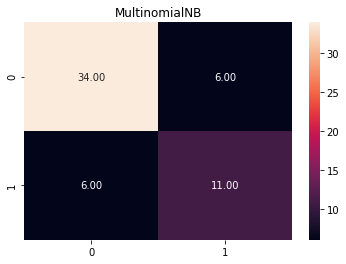

In [ ]:
sns.heatmap(confusion_matrix(y_test, pred_complement), annot = True, fmt = '.2f')
plt.title('MultinomialNB')
plt.show()

In [ ]:
print(classification_report(y_test, pred_complement, digits = 3))

              precision    recall  f1-score   support

           0      0.850     0.850     0.850        40
           1      0.647     0.647     0.647        17

    accuracy                          0.789        57
   macro avg      0.749     0.749     0.749        57
weighted avg      0.789     0.789     0.789        57



In [ ]:
teste = ["dólar tem maior baixa semanal em 9 meses "]

val_pred = multinomial_clf.predict(teste)
val_pred

array([0])

Importar as noticias 

In [ ]:
import tweepy
import re
from nltk.tokenize import sent_tokenize, word_tokenize 

consumer_key = '<chave de acesso>'
consumer_secret = '<senha de acesso do tweet>'
access_token = '<token de acesso>'
access_token_secret = '< senha do token>'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)  
nltk.download('punkt')
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
tweets_text = []
public_tweets = api.search('dolar lang:pt (from:InvestingBrasil OR from:valoreconomico OR from:UOLEconomia)',count =30)
for tweet in public_tweets:
        tweet_tnk_date = []
        dt_obj  = ""
        without_url = re.sub(r'http\S+', "", tweet.text)
        without_url =re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', '', without_url).lower()
        tokens = word_tokenize(without_url)
        filtered_sentence = [w for w in tokens if not w in stopwords]  
        if(datetime.now() - tweet.created_at ).days <3:
                tweet_token = []
                tweet_token.append(without_url)
                tweet_token.append(tweet.created_at)
                tweets_text.append(tweet_token)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
 panda_tweet = pd.DataFrame(tweets_text)
 panda_tweet.rename(columns = {0: "conteudo"},inplace=True)
 panda_tweet.rename(columns = {1: "date"},inplace=True)
 panda_tweet['date'] = panda_tweet['date'].dt.normalize()
 panda_tweet


,conteudo,date
0,dólar cai investidores repensam comércio de re...,2021-04-08
1,dólar cai 123 e fecha a r 5574 menor valor em ...,2021-04-08
2,ouro ultrapassa us 1750 mercado espera rendime...,2021-04-08
3,btg pactual vê dólar a r640 no fim do ano em c...,2021-04-08
4,dólar cai por otimismo externo alívio segue fr...,2021-04-08
5,dólar tem queda de 067 vendido a r 5606 acompa...,2021-04-08
6,dólar abandona queda e fecha em alta com decla...,2021-04-07
7,dólar deve quebrar sequência de perdas de dois...,2021-04-07
8,fala de bolsonaro sobre petrobras pressiona e ...,2021-04-07
9,dólar fecha em alta de 078 cotado a r 56434,2021-04-07


In [ ]:
val_pred = multinomial_clf.predict(panda_tweet['conteudo'])
val_pred

import json
a = np.array(val_pred).tolist()
json_x = json.dumps({"prediction": a})
json_x

'{"prediction": [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]}'

In [ ]:
json_x
jobj = json.loads(json_x)
list = jobj['prediction']
cont_dolar_alto = 0
# list = []
print(len(list))

for predict in list:
  if predict != 1:
    cont_dolar_alto += 1
if len(list) == cont_dolar_alto and  len(list) > 0:
  print("As noticias estão apontando para aumento do dolar de "+str(cont_dolar_alto)+" notícias ")
elif cont_dolar_alto == 0 and len(list) > 0:
  print("Dolar estão apontando para baixa do dolar")
elif cont_dolar_alto > 0 and len(list) > 0:
  print(str(cont_dolar_alto)+" de "+str(len(list))+" notícias estão apontando aumento do dolar")
elif len(list) == 0:
  print("Não foi encontrado noticias de dolar hoje")
  # if cont_dolar_alto == 0 and len(list) > 0:
  #   print("Dolar estão apontando para baixa do dolar")
  # else:
  #   print(str(cont_dolar_alto)+" de "+str(len(list))+" notícias estão apontando aumento do dolar")



18
11 de 18 notícias estão apontando aumento do dolar


In [ ]:
fpr, tpr, treshold = roc_curve(y_test, pred_mult)
roc_auc = auc(fpr, tpr)

fpr_comp, tpr_comp, treshold = roc_curve(y_test, pred_complement)
roc_auc_compl = auc(fpr, tpr)

fpr_svm, tpr_svm, treshold = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(fpr, tpr)


# pred_mult = multinomial_clf.predict(X_test)
# pred_complement = complement_clf.predict(X_test)
# pred_svm = svm_clf.predict(X_test)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr_comp, tpr_comp, 'r', label = 'Comp = %0.2f' % roc_auc_compl)
plt.plot(fpr_svm, tpr_svm, 'y', label = 'SVM
 = %0.2f' % roc_auc_compl)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa de verdadeiro positivo')
plt.xlabel('Taxa de falso positivo')
plt.show()

SyntaxError: ignored